<h1>Homework 1 - Grégoire Boussac</h1>

## 2 - Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from tqdm import tqdm

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution2D, Flatten, MaxPooling2D, Dropout
from keras import optimizers
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


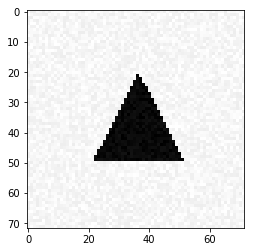

In [3]:
# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    for i in tqdm(range(nb_samples)):
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    for i in tqdm(range(nb_samples)):
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

# 3 - Simple classification

* Utils

In [4]:
def vizualize_weights(model):
    W, b = model.get_weights()
    
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(W[:, 0].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('Rectangle class')
    
    plt.subplot(1, 3, 2)
    plt.imshow(W[:, 1].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('Circle class')

    plt.subplot(1, 3, 3)
    plt.imshow(W[:, 2].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('Triangle class')
    plt.show()

In [5]:
def test_linear_model(model):
    X_test = np.array(generate_a_rectangle())
    X_test = X_test.reshape(1, X_test.shape[0])
    print("Correctly predicted a rectangle : ", model.predict(X_test)[0][0]==1)
    
    X_test, _ = generate_a_triangle()
    X_test = X_test.reshape(1, X_test.shape[0])
    print("Corrrectly predicted a triangle : ", model.predict(X_test)[0][2]==1)
    
    X_test = np.array(generate_a_disk())
    X_test = X_test.reshape(1, X_test.shape[0])
    print("Corrrectly predicted a disk : ", model.predict(X_test)[0][1]==1)

- Create datasets

In [6]:
[X_train, Y_train] = generate_dataset_classification(300, 20)
[X_val, Y_val] = generate_dataset_classification(100, 20)

Y_train_cat = keras.utils.to_categorical(Y_train)
Y_val_cat = keras.utils.to_categorical(Y_val)

nb_classes = len(np.unique(Y_train))

100%|██████████| 100/100 [00:06<00:00, 16.10it/s]


## SGD

<b>N.B.:</b>

During the training of the different models, we will use EarlyStopping.

The idea is to stop the training if no improvement is observed during a certain amount of time.

In [7]:
model = Sequential([
    Dense(nb_classes, input_shape=(X_train.shape[1],)),
    Activation('softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=10e-4)) 

# Fit the model
callbacks = [EarlyStopping(monitor='val_loss', patience=10)]
history = model.fit(X_train, Y_train_cat, validation_data=(X_val, Y_val_cat), epochs=50, callbacks=callbacks)

Train on 300 samples, validate on 100 samples
Epoch 1/50
300/300 [==============================] - 0s 386us/step - loss: 1.2312 - val_loss: 1.1102
Epoch 2/50
300/300 [==============================] - 0s 99us/step - loss: 0.9343 - val_loss: 0.9362
Epoch 3/50
300/300 [==============================] - 0s 97us/step - loss: 0.8361 - val_loss: 0.9007
Epoch 4/50
300/300 [==============================] - 0s 113us/step - loss: 0.8547 - val_loss: 0.7553
Epoch 5/50
300/300 [==============================] - 0s 97us/step - loss: 0.7472 - val_loss: 0.7976
Epoch 6/50
300/300 [==============================] - 0s 96us/step - loss: 0.7121 - val_loss: 0.7487
Epoch 7/50
300/300 [==============================] - 0s 101us/step - loss: 0.6698 - val_loss: 0.7124
Epoch 8/50
300/300 [==============================] - 0s 99us/step - loss: 0.6506 - val_loss: 0.6735
Epoch 9/50
300/300 [==============================] - 0s 104us/step - loss: 0.5999 - val_loss: 0.6224
Epoch 10/50
300/300 [====================

In [8]:
test_linear_model(model)

Correctly predicted a rectangle :  False
Corrrectly predicted a triangle :  True
Corrrectly predicted a disk :  True


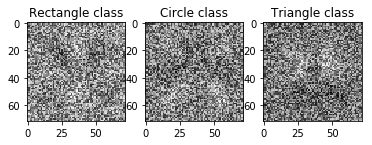

In [9]:
vizualize_weights(model)

* We can note that the model is very to the learning rate.
Changing the magnitude of this parameter can lead to very different results.
* We can also see that, most of the time, SGD optimizer does not lead to very good results. There is no clear pattern in the weight images.

## Adam

In [10]:
# Create the model
model = Sequential([
    Dense(nb_classes, input_shape=(X_train.shape[1],)),
    Activation('softmax')])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam') 

# Fit the model
callbacks = [EarlyStopping(monitor='val_loss', patience=10)]
history = model.fit(X_train, Y_train_cat, validation_data=(X_val, Y_val_cat), epochs=50, callbacks=callbacks)

Train on 300 samples, validate on 100 samples
Epoch 1/50
300/300 [==============================] - 0s 476us/step - loss: 1.9461 - val_loss: 1.6914
Epoch 2/50
300/300 [==============================] - 0s 110us/step - loss: 0.8805 - val_loss: 0.6825
Epoch 3/50
300/300 [==============================] - 0s 104us/step - loss: 0.5030 - val_loss: 0.4400
Epoch 4/50
300/300 [==============================] - 0s 105us/step - loss: 0.4015 - val_loss: 0.3855
Epoch 5/50
300/300 [==============================] - 0s 104us/step - loss: 0.3207 - val_loss: 0.3218
Epoch 6/50
300/300 [==============================] - 0s 103us/step - loss: 0.3005 - val_loss: 0.2724
Epoch 7/50
300/300 [==============================] - 0s 104us/step - loss: 0.2388 - val_loss: 0.2621
Epoch 8/50
300/300 [==============================] - 0s 106us/step - loss: 0.2309 - val_loss: 0.2269
Epoch 9/50
300/300 [==============================] - 0s 107us/step - loss: 0.2190 - val_loss: 0.2212
Epoch 10/50
300/300 [===============

In [11]:
test_linear_model(model)

Correctly predicted a rectangle :  True
Corrrectly predicted a triangle :  True
Corrrectly predicted a disk :  True


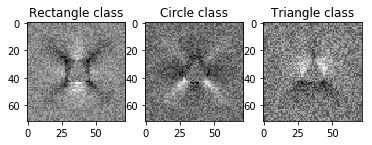

In [ ]:
vizualize_weights(model)

* The Adam optimizer leads to better results. the predictions are almost always correct.
* We can observe shapes when vizualizing the weights
* The Adam optimizer adds a "momentum" parameter, which speeds the convergence, at the cost of more computations than the SGD.
* We can interprete the weights images :
    - a rectangle is detected by the presence of corners (black "stripes")
    - a circle is detected by the absence of corners (white "stripes")
    - a triangle is detected by the presence of three corners (black "stripes"), and the void around the top corner (white areas)

# 5 - A More Difficult Classification Problem

- Generating new dataset

In [ ]:
[X_train, Y_train] = generate_dataset_classification(3000, 20, True)
[X_val, Y_val] = generate_dataset_classification(1000, 20, True)

Y_train_cat = keras.utils.to_categorical(Y_train)
Y_val_cat = keras.utils.to_categorical(Y_val)

nb_classes = len(np.unique(Y_train))

  4%|▍         | 114/3000 [00:09<04:01, 11.93it/s]

- Testing the linear model

In [ ]:
# Create the model
model = Sequential([
    Dense(nb_classes, input_shape=(X_train.shape[1], )),
    Activation('softmax')])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 

# Fit the model
callbacks = [EarlyStopping(monitor='val_loss', patience=10)]
history = model.fit(X_train, Y_train_cat, validation_data=(X_val, Y_val_cat), epochs=50, callbacks=callbacks)

In [ ]:
[X_test, Y_test] = generate_test_set_classification()
[loss, acc] = model.evaluate(X_test, Y_test)
print('Loss = {} ; Accuracy = {}'.format(loss, acc))

- Buidling a CNN

In [ ]:
X_train = X_train.reshape((X_train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1))
X_val = X_val.reshape((X_val.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1))

In [ ]:
# Create the model
model = Sequential([
    Convolution2D(16, kernel_size=(5, 5), input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1, )),
    Activation('relu'),
    MaxPooling2D(pool_size=(3, 3)),
    Flatten(),
    Dense(nb_classes, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 

# Fit the model
callbacks = [EarlyStopping(monitor='val_loss', patience=15)]
history = model.fit(X_train, Y_train_cat, validation_data=(X_val, Y_val_cat),
                    epochs=150, batch_size=32, callbacks=callbacks)

In [ ]:
[X_test, Y_test] = generate_test_set_classification()
X_test = X_test.reshape((X_test.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1))
[loss, acc] = model.evaluate(X_test, Y_test)
print('Loss = {} ; Accuracy = {}'.format(loss, acc))

<b>What is the value of the loss function on this test set when using your deep network ?</b>
<br/>
The crossentropy loss is 0.93, and the accuracy is 0.74 on this test set.

# 6 - A regression problem

In [ ]:
def sort_vertices(Y):
    '''Sort vertices by increasing x-coordinate'''
    Y_ = Y.reshape(-1, 3, 2)
    U = Y_.copy()
    S = np.argsort(Y[:, ::2], axis=1)
    for i, e in enumerate(S):
        U[i, :] = U[i,e]
    
    return U.reshape(-1, 6)

In [ ]:
[X_train, Y_train] = generate_dataset_regression(3000, 20)
[X_val, Y_val] = generate_dataset_regression(1000, 20)

Y_train = sort_vertices(Y_train)
Y_val = sort_vertices(Y_val)

X_train = X_train.reshape(X_train.shape[0], IMAGE_SIZE, -1, 1)
X_val = X_val.reshape(X_val.shape[0], IMAGE_SIZE, -1, 1)

- Vizualize one prediction

In [ ]:
visualize_prediction(X_train[0], Y_train[0])

- Build the model

In [ ]:
# Build the model
model = Sequential([
    Convolution2D(filters=16, kernel_size=5, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)),
    Activation('relu'),
    MaxPooling2D(pool_size=3),
    Convolution2D(filters=32, kernel_size=4),
    Activation('relu'),
    MaxPooling2D(pool_size=3),
    Convolution2D(filters=64, kernel_size=3),
    Activation('relu'),
    MaxPooling2D(pool_size=3),
    Flatten(),
    Dense(500),
    Activation('relu'),
    Dropout(0.1),
    Dense(600),
    Activation('relu'),
    Dropout(0.15),
    Dense(500),
    Activation('relu'),
    Dropout(0.1),
    Dense(6)
])

# Compile the model
model.compile(loss='mse', optimizer='adam')

# Fit the model
callbacks = [EarlyStopping(monitor='val_loss', patience=5)]
model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=10, batch_size=96, callbacks=callbacks)

I used 3 convolutional layers, with increasing filter size, decreasing kernel size, and ReLu activation functions.
I also added 3 intermediate fully connected layers, with dropout to reduce the overfitting.

- Evaluating the model

In [ ]:
[X_test, Y_test] = generate_test_set_regression()
X_test_reshaped = X_test.reshape(X_test.shape[0], IMAGE_SIZE, -1, 1)
Y_test_sorted = sort_vertices(Y_test)
model.evaluate(X_test_reshaped, Y_test_sorted)

# 7 - Image denoising

- Modifying the generate_a_* functions to return pair of images

In [ ]:
np.random.rand()*1000

In [ ]:
MAX_NOISE = 500

def generate_a_rectangle(free_location=True, pair=True):
    noise = np.random.rand() * MAX_NOISE
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right

    if pair:
        return [generate_a_drawing(figsize, U, V, 0), generate_a_drawing(figsize, U, V, noise)]
    else:
        return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(free_location=True, pair=True):
    noise = np.random.rand() * MAX_NOISE
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
        
    if pair:
        return [generate_a_drawing(figsize, U, V, 0), generate_a_drawing(figsize, U, V, noise)]
    else:
        return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(free_location=True, pair=True):
    noise = np.random.rand() * MAX_NOISE
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    if pair:
        imdata_no_noise = generate_a_drawing(figsize, U, V, 0)
        return [imdata_no_noise, imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]
    else:
        return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

- Testing the new functions

In [ ]:
img, noisy_img = generate_a_rectangle()
plt.subplot(1,2,1)
plt.imshow(noisy_img.reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
plt.title('Noisy image')
plt.subplot(1, 2, 2)
plt.imshow(img.reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
plt.title('Image')
plt.show()

img, noisy_img = generate_a_disk()
plt.subplot(1,2,1)
plt.imshow(noisy_img.reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
plt.title('Noisy image')
plt.subplot(1, 2, 2)
plt.imshow(img.reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
plt.title('Image')
plt.show()

img, noisy_img, _ = generate_a_triangle()
plt.subplot(1,2,1)
plt.imshow(noisy_img.reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
plt.title('Noisy image')
plt.subplot(1, 2, 2)
plt.imshow(img.reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
plt.title('Image')
plt.show()